# Diel Warming

In [1]:
# imports
import os
import xarray

import numpy as np
from scipy import stats
from scipy.interpolate import interp1d 

from gsw import conversions, density
import gsw

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator 

import seaborn as sns

import pandas

from cugn import grid_utils
from cugn import utils as cugn_utils
from cugn import io as cugn_io
from cugn import annualcycle

In [31]:
def gen_cb(img, lbl, csz = 17.):
    cbaxes = plt.colorbar(img, pad=0., fraction=0.030)
    cbaxes.set_label(lbl, fontsize=csz)
    cbaxes.ax.tick_params(labelsize=csz)

# Load CUGN

In [2]:
line = '90.0'
#
items = cugn_io.load_up(line)#, gextrem='low')
grid_extrem = items[0]
ds = items[1]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


# Layer

In [3]:
iz = 0

# Hour of day

In [4]:
ds.time

<xarray.DataArray 'time' (profile: 54842)> Size: 439kB
array(['2006-10-19T17:51:00.000000000', '2006-10-19T18:32:02.000000000',
       '2006-10-19T19:34:28.000000000', ...,
       '2023-03-20T14:06:54.000000000', '2023-03-20T14:55:10.000000000',
       '2023-03-20T15:42:26.000000000'], dtype='datetime64[ns]')
Coordinates:
  * profile  (profile) int32 219kB 0 1 2 3 4 5 ... 54837 54838 54839 54840 54841
    lat      (profile) float64 439kB 33.44 33.44 33.44 ... 32.89 32.89 32.88
    lon      (profile) float64 439kB -117.7 -117.7 -117.7 ... -117.3 -117.3
    lat_uv   (profile) float64 439kB 33.44 33.44 33.44 ... 32.89 32.89 32.88
    lon_uv   (profile) float64 439kB -117.7 -117.7 -117.7 ... -117.3 -117.3
    time     (profile) datetime64[ns] 439kB 2006-10-19T17:51:00 ... 2023-03-2...
    time_uv  (profile) datetime64[ns] 439kB 2006-10-19T17:41:00 ... 2023-03-2...
Attributes:
    standard_name:          time
    long_name:              Time
    axis:                   T
    coverage_content_type:  coordinate
    comment:                The estimated time of the midpoint of the profile...

In [41]:
ns = ds.time.data.astype('datetime64[ns]').astype('int64') % (24 * 60 * 60 * 1_000_000_000)
decimal_hours = ns / (60 * 60 * 1_000_000_000) 
# Offset to CA
decimal_hours -= 8
next_day = decimal_hours < 0
decimal_hours[next_day] += 24

# 2D Histogram

In [47]:
bins_SO = np.linspace(0.8, 1.3, 50)
bins_hour = np.linspace(0, 24, 25)

In [48]:
gd = np.isfinite(ds.SO.data[iz,:])

In [49]:
counts, xedges, yedges = np.histogram2d(
                decimal_hours[gd],
                ds.SO.data[iz,gd], 
                bins=[bins_hour, bins_SO])

In [50]:
# PDF
dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]

p_norm = np.sum(counts) * (dx * dy)
consv_pdf = counts / p_norm

## Running stats

In [55]:
yedges.size

50

In [56]:
consv_pdf.shape

(24, 49)

In [61]:
consv_pdf.shape
SO_vals = yedges[:-1] + (yedges[1]-yedges[0])/2.
avg_SOs = []
for hour in range(consv_pdf.shape[0]):
    avg_SO = np.sum(SO_vals * consv_pdf[hour,:]) / np.sum(consv_pdf[hour,:])
    avg_SOs.append(avg_SO)
#
avg_SOs = np.array(avg_SOs)
avg_SOs.size

24

/tmp/ipykernel_163600/3550532828.py:6: RuntimeWarning: divide by zero encountered in log10
  img = ax.pcolormesh(xedges, yedges, np.log10(consv_pdf.T),


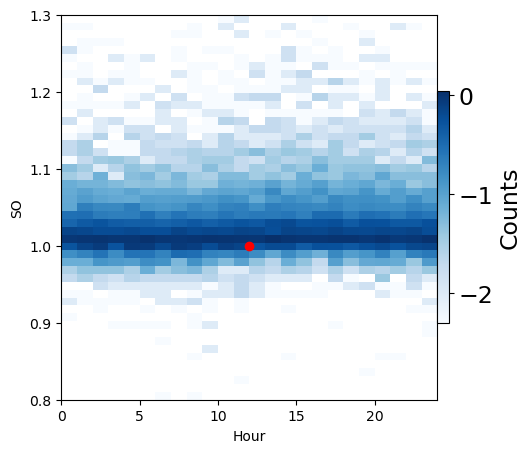

In [52]:
cmap = 'Blues'

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
img = ax.pcolormesh(xedges, yedges, np.log10(consv_pdf.T),
                                cmap=cmap)
#ax.plot([12.], [1.], 'ro')
gen_cb(img, 'Counts')
#
ax.set_xlabel('Hour')
ax.set_ylabel('SO')

plt.show()